In [155]:
# Step 0. Load libraries and custom modules ----------------------------
# Data processing ------------------------------------------------------
import pandas as pd
import numpy as np
import joblib
import logging
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning -----------------------------------------------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score,  
                             f1_score,
                             roc_curve,
                             auc,
                             classification_report,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)  

# Custom functions -----------------------------------------------------
def sklearn_vif(exogs, data):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}
    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    return df_vif

In [156]:
# Step 1. Load data ----------------------------------------------------
# 1.1 Read data
train = pd.read_csv('../data/datatraining.txt')
test = pd.read_csv('../data/datatest.txt')

In [157]:
# 1.2 Get info from training
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


In [158]:
# 1.3 Get a sample from training
train.sample(6)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
5908,2015-02-08 20:18:00,19.390,27.5000,0.0,436.50,0.003825,0
5469,2015-02-08 12:59:00,20.340,29.2000,273.0,427.50,0.004311,0
7210,2015-02-09 18:00:00,22.075,37.8975,433.0,1819.25,0.006243,1
5887,2015-02-08 19:57:00,19.390,27.6000,0.0,437.50,0.003839,0
1398,2015-02-05 17:08:00,22.245,25.5500,433.0,1010.00,0.004239,1
2206,2015-02-06 06:36:00,20.290,18.7000,0.0,439.00,0.002745,0


In [159]:
# Step 2. Perform EDA
# 2.1 Get basic summary
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.0,20.619084,1.016916,19.000000,19.700000,20.390000,21.390000,23.180000
Humidity,8143.0,25.731507,5.531211,16.745000,20.200000,26.222500,30.533333,39.117500
Light,8143.0,119.519375,194.755805,0.000000,0.000000,0.000000,256.375000,1546.333333
CO2,8143.0,606.546243,314.320877,412.750000,439.000000,453.500000,638.833333,2028.500000
HumidityRatio,8143.0,0.003863,0.000852,0.002674,0.003078,0.003801,0.004352,0.006476
Occupancy,8143.0,0.212330,0.408982,0.000000,0.000000,0.000000,0.000000,1.000000


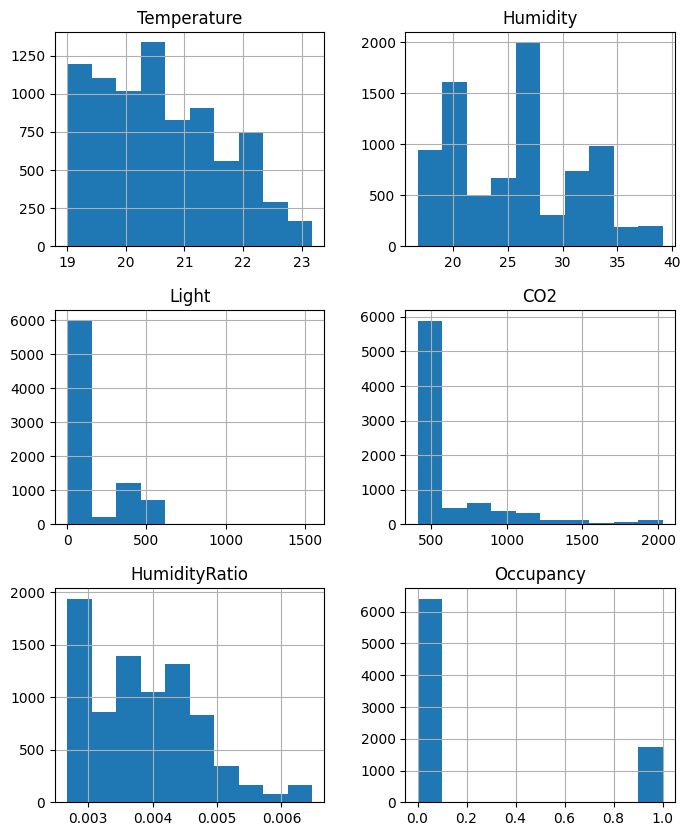

In [160]:
# 2.2 Perform univariate analysis
train.hist(figsize=(8,10))
plt.show()

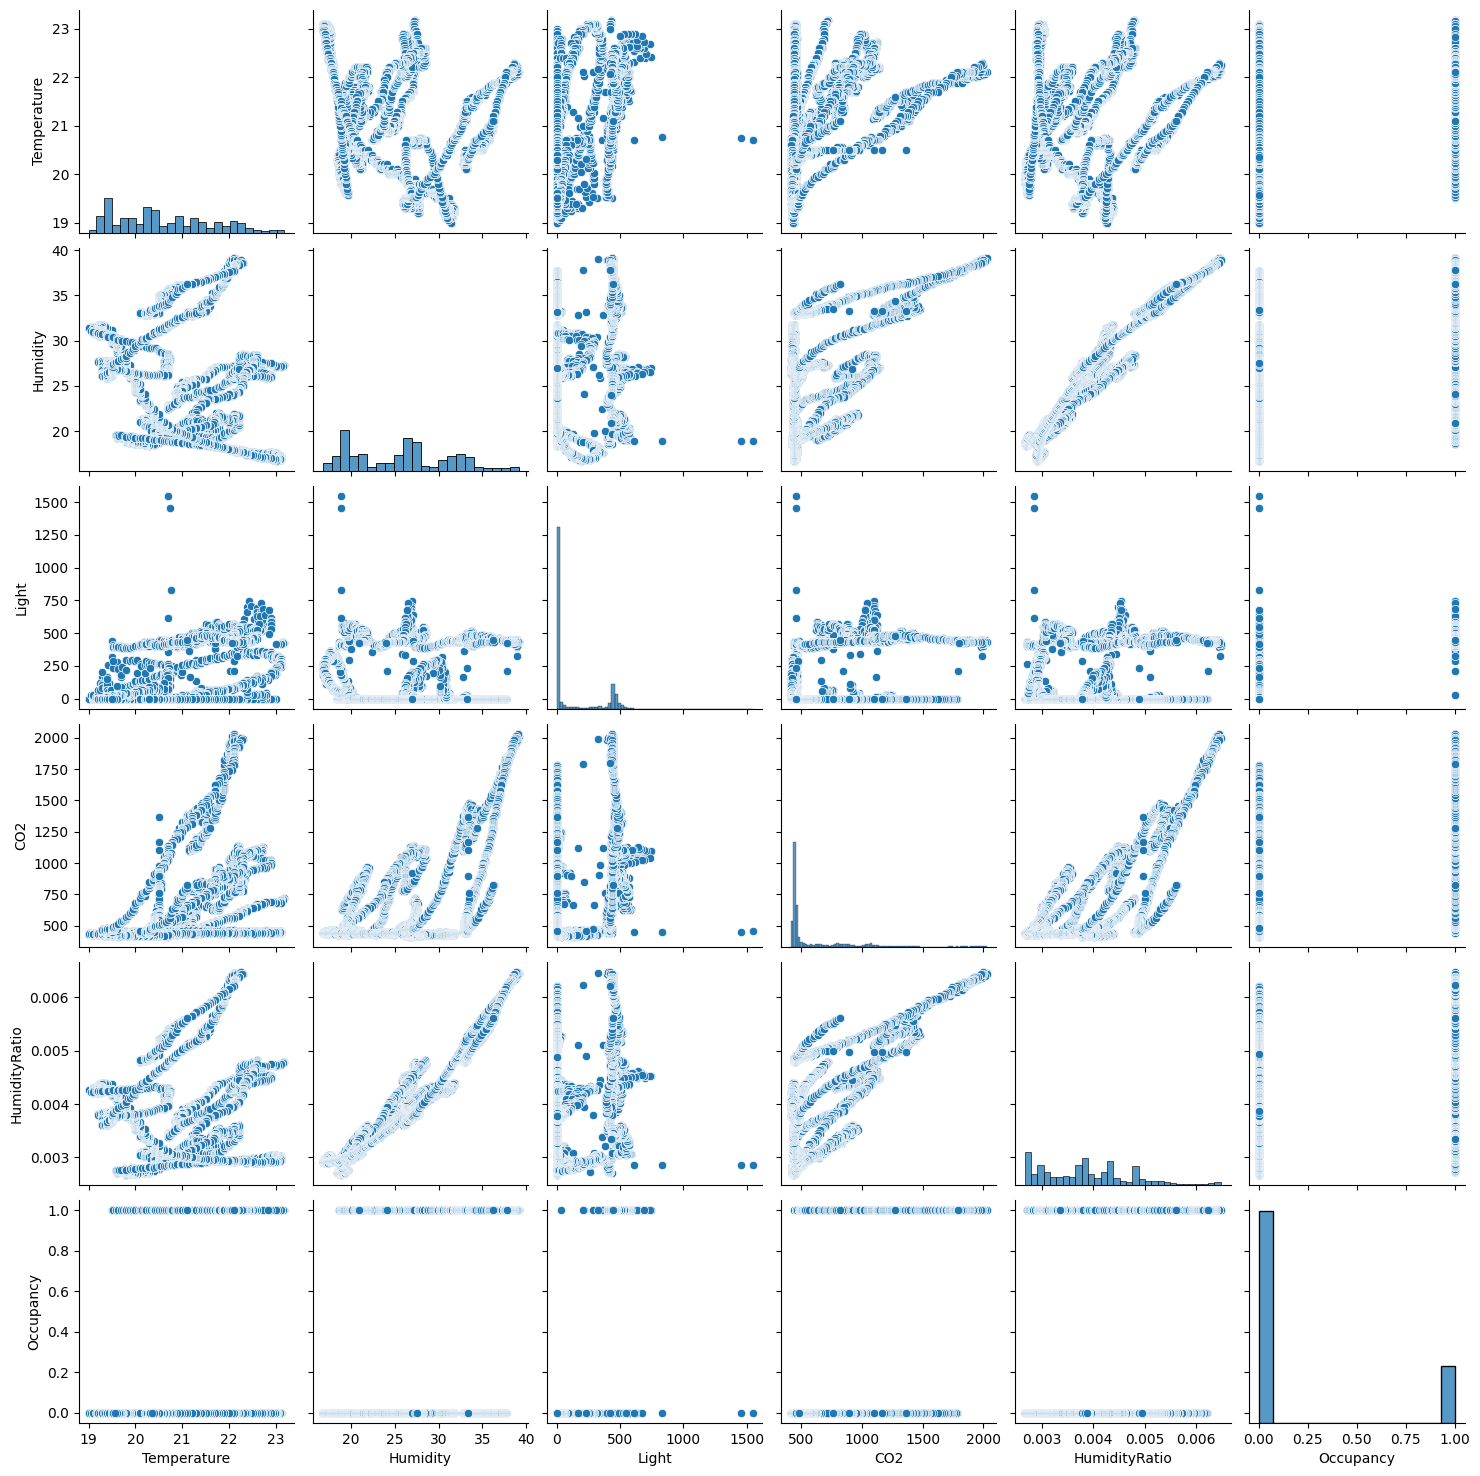

In [161]:
# 2.3 Perform bivariate analysis
sns.pairplot(data=train)
plt.show()

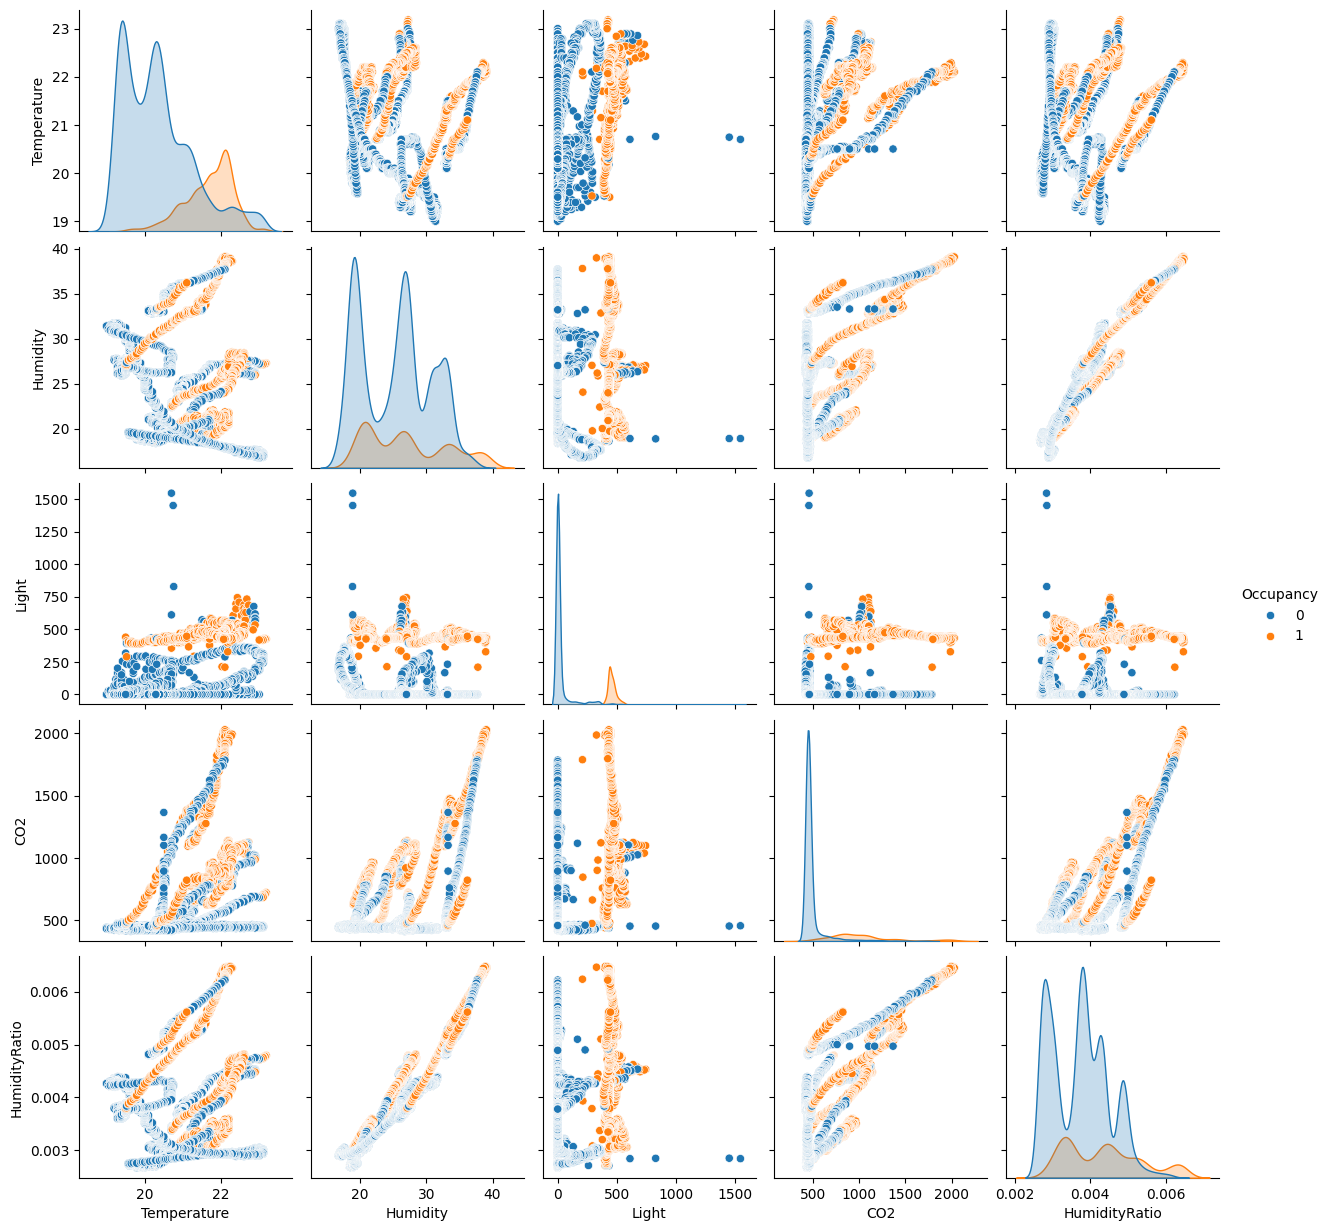

In [162]:
# 2.4 Perform bivariate analysis with the target effect
sns.pairplot(data=train, hue="Occupancy")
plt.show()

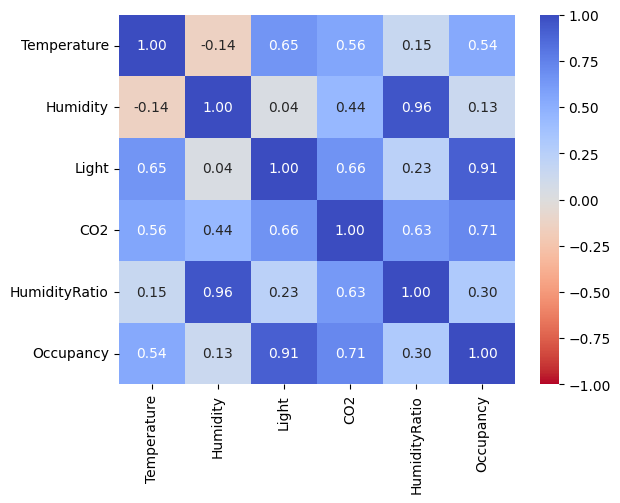

In [163]:
# 2.5 Analyze correlation
sns.heatmap(train.drop('date',axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm_r', vmin=-1, vmax=1)
plt.show()

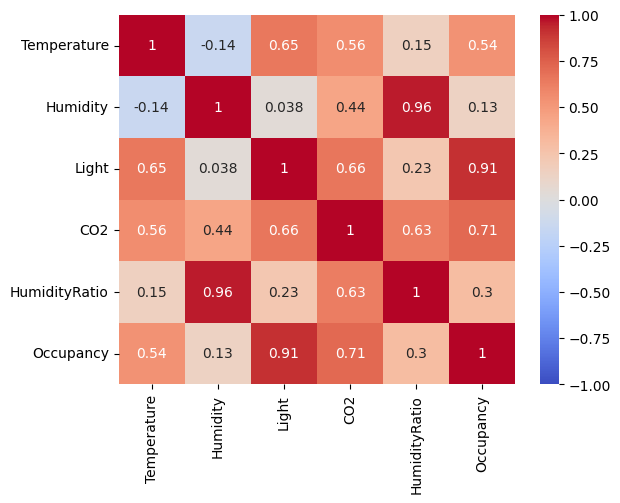

In [164]:
sns.heatmap(train.drop('date',axis=1).corr(), annot=True,vmin=-1,vmax=1, cmap='coolwarm')
plt.show()

In [165]:
# 2.6 Analyze variance inflation factor
train_nodate = train.drop('date',axis=1)
exogs = train_nodate.drop('Occupancy', axis=1).columns.tolist()
sklearn_vif(exogs=exogs, data=train_nodate)

,VIF,Tolerance
Temperature,45.050099,0.022198
Humidity,571.690158,0.001749
Light,2.780892,0.359597
CO2,6.691804,0.149437
HumidityRatio,617.970179,0.001618


In [166]:
# Step 3. Create model
# 3.1 Split predictors and target
X = train.drop(columns=['Occupancy','date','HumidityRatio'], axis=1)
y = train['Occupancy']

In [167]:
# 3.2 Fit the model and calculate accurcy on train data
logistic_model = LogisticRegression(class_weight='balanced')
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', logistic_model)
])
pipe.fit(X, y)
print(f'Accuracy with train: {pipe.score(X, y):.3f}')

Accuracy with train: 0.988


In [168]:
# 3.3 Split test data
X_test = test.drop(columns=['Occupancy','date','HumidityRatio'], axis=1)
y_test = test['Occupancy']

Accuracy: 0.979
F1 score: 0.971
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665



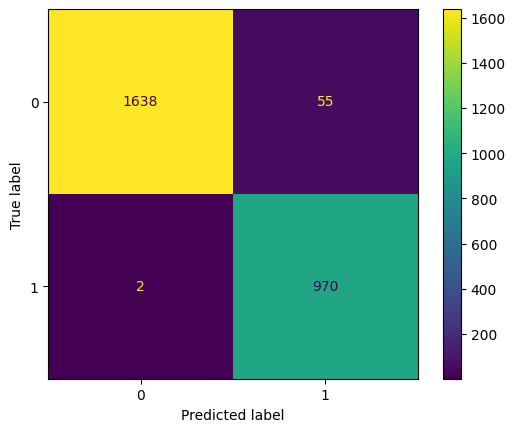

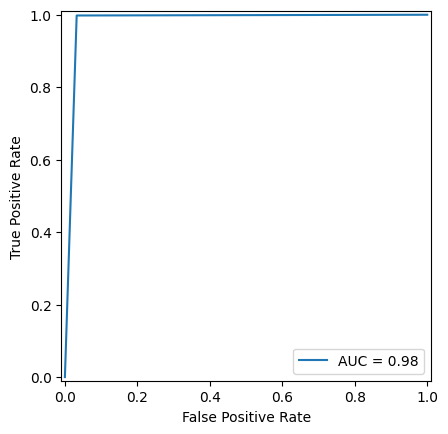

In [169]:
# 3.4 Predict on test data
y_hat = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
auc_val = auc(fpr, tpr)
print(f'Accuracy: {accuracy_score(y_test, y_hat):.3f}')
print(f'F1 score: {f1_score(y_test, y_hat):.3f}')
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_val)
disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test, pos_label=1)
disp.plot()
plt.show()


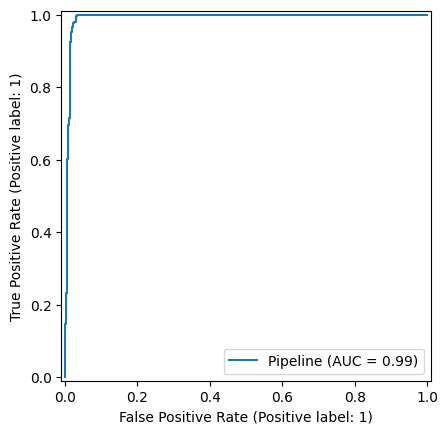

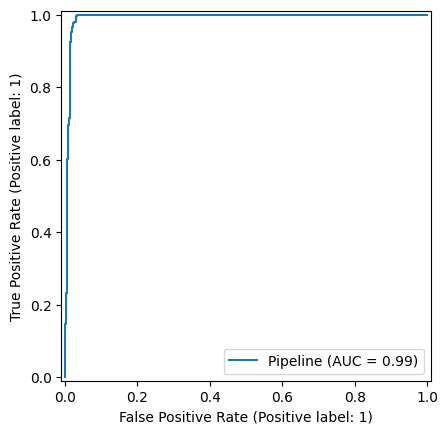

In [179]:
display(RocCurveDisplay.from_estimator(pipe, X_test, y_test, pos_label=1).plot())